# Bayesian Network: AirBnb houses in Bologna
## Importing libraries

In [104]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import PC, HillClimbSearch, MmhcEstimator
from pgmpy.base import DAG

import networkx as nx
import matplotlib.pyplot as plt

print('Libraries imported')

Libraries imported


## Loading Airbnb database

In [50]:
listings = pd.read_csv("listings.csv")
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42196,https://www.airbnb.com/rooms/42196,20211217003510,2021-12-17,50 sm Studio in the historic centre,<b>The space</b><br />Really cozy and typical ...,NaN,https://a0.muscache.com/pictures/4775726/68044...,184487,https://www.airbnb.com/users/show/184487,...,4.85,4.85,4.70,NaN,t,1,1,0,0,1.32
1,46352,https://www.airbnb.com/rooms/46352,20211217003510,2021-12-17,A room in Pasolini's house,"Simple, cozy and silent room in a lived house ...",In the very nearby you have Via Saragozza whic...,https://a0.muscache.com/pictures/9f94acc3-98fc...,467810,https://www.airbnb.com/users/show/467810,...,4.79,4.80,4.59,NaN,f,2,0,2,0,2.20
2,59697,https://www.airbnb.com/rooms/59697,20211217003510,2021-12-17,COZY LARGE BEDROOM in the city center,"Cozy, spacious and bright double bedroom, in a...",NaN,https://a0.muscache.com/pictures/ac0528c4-b26f...,286688,https://www.airbnb.com/users/show/286688,...,4.79,4.82,4.66,NaN,f,2,0,2,0,2.18


## Preprocessing
1. Encoding amenities as one-hot array

In [51]:
listings = pd.concat([listings, listings['amenities'].str.get_dummies(sep='", "').astype(bool)[['Kitchen', 'Wifi']]], axis=1)
listings = listings.rename(columns = {'Kitchen': 'kitchen', 'Wifi': 'wifi'})
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,kitchen,wifi
0,42196,https://www.airbnb.com/rooms/42196,20211217003510,2021-12-17,50 sm Studio in the historic centre,<b>The space</b><br />Really cozy and typical ...,NaN,https://a0.muscache.com/pictures/4775726/68044...,184487,https://www.airbnb.com/users/show/184487,...,4.70,NaN,t,1,1,0,0,1.32,True,False
1,46352,https://www.airbnb.com/rooms/46352,20211217003510,2021-12-17,A room in Pasolini's house,"Simple, cozy and silent room in a lived house ...",In the very nearby you have Via Saragozza whic...,https://a0.muscache.com/pictures/9f94acc3-98fc...,467810,https://www.airbnb.com/users/show/467810,...,4.59,NaN,f,2,0,2,0,2.20,True,False
2,59697,https://www.airbnb.com/rooms/59697,20211217003510,2021-12-17,COZY LARGE BEDROOM in the city center,"Cozy, spacious and bright double bedroom, in a...",NaN,https://a0.muscache.com/pictures/ac0528c4-b26f...,286688,https://www.airbnb.com/users/show/286688,...,4.66,NaN,f,2,0,2,0,2.18,True,False


2. Selecting relevant columns for the Bayesian Network

In [52]:
columns = ['neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms_text', 'price', 'kitchen', 'wifi']
listings_selection = listings.loc[:, columns]
listings_selection.head(3)

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,2,1 bath,$68.00,True,False
1,Porto - Saragozza,Private room,2,1 shared bath,$29.00,True,False
2,Santo Stefano,Private room,2,1 shared bath,$50.00,True,False


3. Parsing price into float

In [53]:
listings_selection.loc[:, 'price'] = listings_selection.loc[:, 'price'].str.replace(r'[$|,]', '', regex=True).astype(float)
listings_selection.head(3)

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,2,1 bath,68.0,True,False
1,Porto - Saragozza,Private room,2,1 shared bath,29.0,True,False
2,Santo Stefano,Private room,2,1 shared bath,50.0,True,False


5. Encoding shared bathroom into boolean

In [54]:
listings_selection.loc[:, 'bathrooms_text'] = listings_selection.loc[:, 'bathrooms_text'].str.contains('shared')
listings_selection = listings_selection.rename(columns = {'bathrooms_text': 'shared_bathroom'})
listings_selection.head(3)

,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,2,False,68.0,True,False
1,Porto - Saragozza,Private room,2,True,29.0,True,False
2,Santo Stefano,Private room,2,True,50.0,True,False


6. Discretizing price into 4 categories: '0-50', '50-150', '150-500', '>500'

In [55]:
listings_selection['price'], bins = pd.cut(listings_selection['price'], [0, 50, 150, 500, 10000], labels=['0-50', '50-150', '150-500', '>500'], retbins=True)
listings_selection.head(3)


,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,2,False,50-150,True,False
1,Porto - Saragozza,Private room,2,True,0-50,True,False
2,Santo Stefano,Private room,2,True,0-50,True,False


In [56]:
listings_selection.groupby(by='price').count()

,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,kitchen,wifi
price,,,,,,
0-50,813,813,813,813,813,813
50-150,2242,2242,2242,2241,2242,2242
150-500,318,318,318,314,318,318
>500,80,80,80,80,80,80


7. Discretizing accomodates into 3 categories: '1-2', '2-4', '4+'

In [57]:
listings_selection['accommodates'], bins = pd.cut(listings_selection['accommodates'], [0, 2, 4, 10000], labels=['0-2', '3-4', '5+'], retbins=True)
listings_selection.head(3)


,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,0-2,False,50-150,True,False
1,Porto - Saragozza,Private room,0-2,True,0-50,True,False
2,Santo Stefano,Private room,0-2,True,0-50,True,False


8. Counting NaN values and removing them

In [58]:
print(f'Number of rows before cleaning: {listings_selection.shape[0]}')
listings_cleaned = listings_selection.dropna()
print(f'Number of rows after cleaning: {listings_cleaned.shape[0]}')


Number of rows before cleaning: 3453
Number of rows after cleaning: 3448


## Structure learning

In [73]:
listings_estimate = listings_cleaned.loc[:, ["neighbourhood_cleansed", "room_type", "accommodates", "shared_bathroom", "price", "kitchen", "wifi"]]
listings_estimate.head(5)

,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,0-2,False,50-150,True,False
1,Porto - Saragozza,Private room,0-2,True,0-50,True,False
2,Santo Stefano,Private room,0-2,True,0-50,True,False
3,Santo Stefano,Entire home/apt,0-2,False,50-150,True,True
4,Porto - Saragozza,Private room,0-2,True,0-50,False,False


In [99]:
c = PC(data=listings_estimate)
skeleton= c.estimate()
skeleton.edges()

  0%|          | 0/5 [00:00<?, ?it/s]

OutEdgeView([('accommodates', 'kitchen'), ('accommodates', 'price'), ('accommodates', 'room_type'), ('kitchen', 'room_type'), ('price', 'room_type'), ('shared_bathroom', 'price'), ('shared_bathroom', 'room_type'), ('wifi', 'room_type')])

In [102]:
skeleton.get_leaves()

['room_type']

### Drawing graph

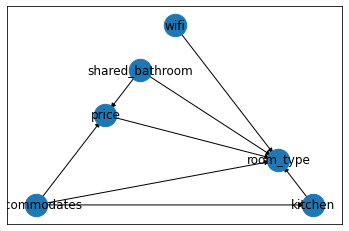

In [101]:
G = nx.DiGraph()
G.add_edges_from(skeleton.edges())
plt.show()

pos = nx.planar_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True)
plt.show()

In [80]:
c = HillClimbSearch(data=listings_estimate)
model = c.estimate()
model.edges()

  0%|          | 0/1000000 [00:00<?, ?it/s]

OutEdgeView([('room_type', 'shared_bathroom'), ('room_type', 'accommodates'), ('room_type', 'kitchen'), ('room_type', 'wifi'), ('room_type', 'price'), ('accommodates', 'kitchen'), ('shared_bathroom', 'price'), ('shared_bathroom', 'kitchen'), ('price', 'neighbourhood_cleansed'), ('price', 'accommodates'), ('kitchen', 'wifi')])

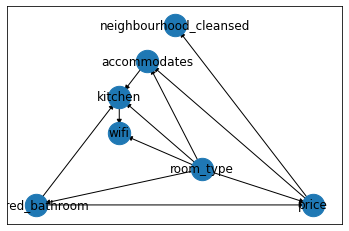

In [93]:
G = nx.DiGraph()
G.add_edges_from(model.edges())
plt.show()

pos = nx.planar_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True)
plt.show()

In [105]:
c = MmhcEstimator(data=listings_estimate)
model = c.estimate()
model.edges()

  0%|          | 0/1000000 [00:00<?, ?it/s]

OutEdgeView([('room_type', 'shared_bathroom'), ('room_type', 'kitchen'), ('accommodates', 'room_type'), ('accommodates', 'price'), ('price', 'room_type'), ('price', 'neighbourhood_cleansed'), ('price', 'kitchen')])

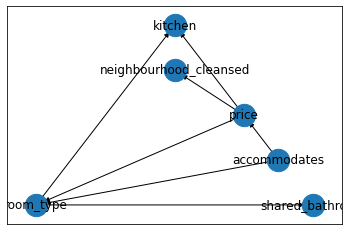

In [106]:
G = nx.DiGraph()
G.add_edges_from(model.edges())
plt.show()

pos = nx.planar_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True)
plt.show()

## Probabilities calculation

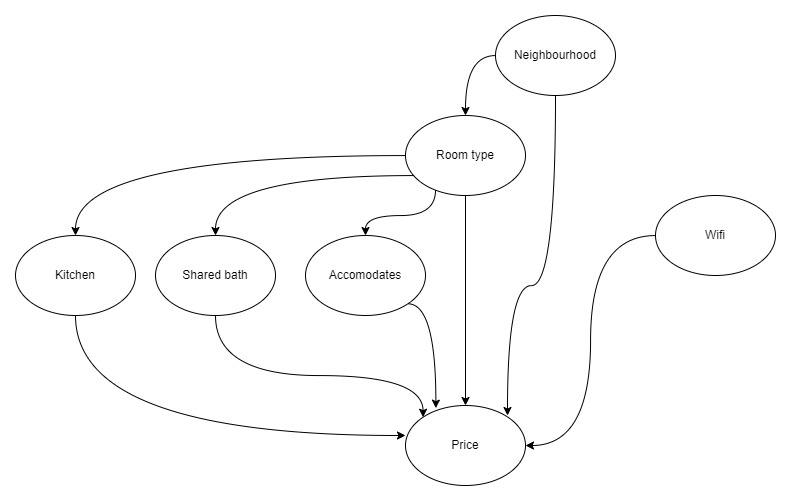

### Neighbourhood
#### Prior probabilities of neighbourhood

In [71]:
neighbourhood_prob_v = listings_cleaned.groupby(['neighbourhood_cleansed']).count()[['id']] / listings_cleaned.shape[0]
display(neighbourhood_prob_v)

neighbourhood_prob = np.array(neighbourhood_prob_v).reshape((neighbourhood_c, 1))

,id
neighbourhood_cleansed,
Borgo Panigale - Reno,0.042343
Navile,0.116879
Porto - Saragozza,0.337877
San Donato - San Vitale,0.121520
Santo Stefano,0.345998
Savena,0.035383


#### Values and cardinality of neighbourhood

In [72]:
neighbourhood_v = {k: v for v, k in enumerate(neighbourhood_prob_v.index)}
print(f'Values: {neighbourhood_v}')
neighbourhood_c = len(neighbourhood_v)
print(f'Cardinality: {neighbourhood_c}')

Values: {'Borgo Panigale - Reno': 0, 'Navile': 1, 'Porto - Saragozza': 2, 'San Donato - San Vitale': 3, 'Santo Stefano': 4, 'Savena': 5}
Cardinality: 6


### Wifi
#### Prior probabilities of wifi

In [73]:
wifi_prob_v = listings_cleaned.groupby(['wifi']).count()[['id']] / listings_cleaned.shape[0]
display(wifi_prob_v)

wifi_prob = np.array(wifi_prob_v).reshape((wifi_c, 1))

,id
wifi,
False,0.566125
True,0.433875


#### Values and cardinality of wifi

In [74]:
wifi_v = {k: v for v, k in enumerate(wifi_prob_v.index)}
print(f'Values: {wifi_v}')
wifi_c = len(wifi_v)
print(f'Cardinality: {wifi_c}')

Values: {False: 0, True: 1}
Cardinality: 2


### Room type
#### Conditional probabilities of room type
Number of listings for each room type for each neighbourhood

In [75]:
roomtype_neighbourhood_count = listings_cleaned.groupby(['room_type', 'neighbourhood_cleansed']).size()
roomtype_neighbourhood_count

room_type        neighbourhood_cleansed 
Entire home/apt  Borgo Panigale - Reno      107
                 Navile                     250
                 Porto - Saragozza          842
                 San Donato - San Vitale    280
                 Santo Stefano              924
                 Savena                      73
Hotel room       Navile                       3
                 Porto - Saragozza           16
                 San Donato - San Vitale      1
                 Santo Stefano               27
Private room     Borgo Panigale - Reno       39
                 Navile                     149
                 Porto - Saragozza          297
                 San Donato - San Vitale    134
                 Santo Stefano              237
                 Savena                      47
Shared room      Navile                       1
                 Porto - Saragozza           10
                 San Donato - San Vitale      4
                 Santo Stefano                5

Number of listings for each neighbourhood

In [76]:
neighbourhood_count = listings_cleaned.groupby(['neighbourhood_cleansed']).size()
neighbourhood_count

neighbourhood_cleansed
Borgo Panigale - Reno       146
Navile                      403
Porto - Saragozza          1165
San Donato - San Vitale     419
Santo Stefano              1193
Savena                      122
dtype: int64

Conditional probabilities of room type, given the neighbourhood

In [77]:
roomtype_prob = (roomtype_neighbourhood_count / neighbourhood_count).unstack(fill_value=0)
display(roomtype_prob)

neighbourhood_cleansed,Borgo Panigale - Reno,Navile,Porto - Saragozza,San Donato - San Vitale,Santo Stefano,Savena
room_type,,,,,,
Entire home/apt,0.732877,0.620347,0.722747,0.668258,0.774518,0.598361
Hotel room,0.000000,0.007444,0.013734,0.002387,0.022632,0.000000
Private room,0.267123,0.369727,0.254936,0.319809,0.198659,0.385246
Shared room,0.000000,0.002481,0.008584,0.009547,0.004191,0.016393


#### Values and cardinality of room type

In [78]:
roomtype_v = {k: v for v, k in enumerate(roomtype_prob.index)}
print(f'Values: {roomtype_v}')
roomtype_c = len(roomtype_v)
print(f'Cardinality: {roomtype_c}')


Values: {'Entire home/apt': 0, 'Hotel room': 1, 'Private room': 2, 'Shared room': 3}
Cardinality: 4


### Kitchen
#### Conditional probabilities of kitchen
Number of listings with and without kitchen for each room type

In [79]:
kitchen_roomtype_count = listings_cleaned.groupby(['kitchen', 'room_type']).size()
kitchen_roomtype_count

kitchen  room_type      
False    Entire home/apt     145
         Hotel room           36
         Private room        410
         Shared room           5
True     Entire home/apt    2331
         Hotel room           11
         Private room        493
         Shared room          17
dtype: int64

Number of listings for each room type

In [80]:
roomtype_count = listings_cleaned.groupby(['room_type']).size()
roomtype_count

room_type
Entire home/apt    2476
Hotel room           47
Private room        903
Shared room          22
dtype: int64

Conditional probabilities of the presence of a kitchen, given the room type

In [81]:
kitchen_prob = (kitchen_roomtype_count / roomtype_count).unstack(fill_value=0)
display(kitchen_prob)

room_type,Entire home/apt,Hotel room,Private room,Shared room
kitchen,,,,
False,0.058562,0.765957,0.454042,0.227273
True,0.941438,0.234043,0.545958,0.772727


#### Values and cardinality of kitchen

In [82]:
kitchen_v = {k: v for v, k in enumerate(kitchen_prob.index)}
print(f'Values: {kitchen_v}')
kitchen_c = len(kitchen_v)
print(f'Cardinality: {kitchen_c}')

Values: {False: 0, True: 1}
Cardinality: 2


### Shared bath
#### Shared bath conditional probabilities
Number of listings with and without shared bathroom for each room type

In [83]:
sharedbath_roomtype_count = listings_cleaned.groupby(['shared_bathroom', 'room_type']).size()
sharedbath_roomtype_count

shared_bathroom  room_type      
False            Entire home/apt    2476
                 Hotel room           43
                 Private room        470
True             Hotel room            4
                 Private room        433
                 Shared room          22
dtype: int64

Number of listings for each room type

In [84]:
roomtype_count

room_type
Entire home/apt    2476
Hotel room           47
Private room        903
Shared room          22
dtype: int64

Conditional probabilities of the presence of a shared bathroom, given the room type

In [85]:
sharedbath_prob = (sharedbath_roomtype_count / roomtype_count).unstack(fill_value=0)
display(sharedbath_prob)

room_type,Entire home/apt,Hotel room,Private room,Shared room
shared_bathroom,,,,
False,1.0,0.914894,0.520487,0.0
True,0.0,0.085106,0.479513,1.0


#### Values and cardinality of shared bathroom

In [86]:
sharedbathroom_v = {k: v for v, k in enumerate(sharedbath_prob.index)}
print(f'Values: {sharedbathroom_v}')
sharedbathroom_c = len(sharedbathroom_v)
print(f'Cardinality: {sharedbathroom_c}')

Values: {False: 0, True: 1}
Cardinality: 2


### Accommodates
#### Accommodates conditional probabilities
Number of listings for each number of accommodates for each room type

In [87]:
accommodates_roomtype_count = listings_cleaned.groupby(['accommodates', 'room_type']).size()
accommodates_roomtype_count

accommodates  room_type      
1             Entire home/apt     17
              Private room       137
              Shared room          6
2             Entire home/apt    583
              Hotel room          29
              Private room       599
              Shared room         12
3             Entire home/apt    443
              Hotel room           9
              Private room       104
              Shared room          3
4             Entire home/apt    945
              Hotel room           6
              Private room        49
              Shared room          1
5             Entire home/apt    204
              Hotel room           2
              Private room         4
6             Entire home/apt    170
              Private room         4
7             Entire home/apt     42
              Hotel room           1
              Private room         2
8             Entire home/apt     43
9             Entire home/apt      9
10            Entire home/apt      8
11      

Number of listings for each room type

In [88]:
roomtype_count

room_type
Entire home/apt    2476
Hotel room           47
Private room        903
Shared room          22
dtype: int64

Conditional probabilities of accommodates, given the room type

In [89]:
accommodates_prob = (accommodates_roomtype_count / roomtype_count).unstack(fill_value=0)
display(accommodates_prob)

room_type,Entire home/apt,Hotel room,Private room,Shared room
accommodates,,,,
1,0.006866,0.000000,0.151717,0.272727
2,0.235460,0.617021,0.663344,0.545455
3,0.178918,0.191489,0.115172,0.136364
4,0.381664,0.127660,0.054264,0.045455
5,0.082391,0.042553,0.004430,0.000000
6,0.068659,0.000000,0.004430,0.000000
7,0.016963,0.021277,0.002215,0.000000
8,0.017367,0.000000,0.000000,0.000000
9,0.003635,0.000000,0.000000,0.000000


#### Values and cardinality of accommodates

In [90]:
accommodates_v = {k: v for v, k in enumerate(accommodates_prob.index)}
print(f'Values: {accommodates_v}')
accommodates_c = len(accommodates_v)
print(f'Cardinality: {accommodates_c}')

Values: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15}
Cardinality: 16


### Price
#### Price conditional probabilities
Number of listings for each price category for each value of neighbourhood, wifi, room type, kitchen, shared bathroom and accommodates

In [91]:
price_alltheother_count = listings_cleaned.groupby(['price', 'neighbourhood_cleansed', 'wifi', 'room_type', 'kitchen', 'shared_bathroom', 'accommodates']).size()
price_alltheother_count

price  neighbourhood_cleansed  wifi   room_type        kitchen  shared_bathroom  accommodates
0-50   Borgo Panigale - Reno   False  Entire home/apt  False    False            1               0
                                                                                 2               0
                                                                                 3               0
                                                                                 4               0
                                                                                 5               0
                                                                                                ..
>500   Savena                  True   Shared room      True     True             12              0
                                                                                 13              0
                                                                                 14              0
               

Number of listings for each value of neighbourhood, wifi, room type, kitchen, shared bathroom and accommodate

In [92]:
alltheother_count = listings_cleaned.groupby(['neighbourhood_cleansed', 'wifi', 'room_type', 'kitchen', 'shared_bathroom', 'accommodates']).size()
alltheother_count

neighbourhood_cleansed  wifi   room_type        kitchen  shared_bathroom  accommodates
Borgo Panigale - Reno   False  Entire home/apt  False    False            4                3
                                                True     False            1                2
                                                                          2               17
                                                                          3               14
                                                                          4               27
                                                                                          ..
Savena                  True   Private room     True     False            3                1
                                                         True             1                2
                                                                          2               11
                                                                          4 

Conditional probabilities of each price category, given the value of neighbourhood, wifi, room type, kitchen, shared bathroom and accommodate


In [93]:
price_prob = (price_alltheother_count / alltheother_count).unstack(fill_value=0)
price_prob = price_prob.fillna(0).T
display(price_prob)

neighbourhood_cleansed Borgo Panigale - Reno                                \
wifi                                   False                                 
room_type                    Entire home/apt                                 
kitchen                                False                                 
shared_bathroom                        False                                 
accommodates                              1    2    3         4    5    6    
price                                                                        
0-50                                     0.0  0.0  0.0  0.000000  0.0  0.0   
50-150                                   0.0  0.0  0.0  0.666667  0.0  0.0   
150-500                                  0.0  0.0  0.0  0.333333  0.0  0.0   
>500                                     0.0  0.0  0.0  0.000000  0.0  0.0   

neighbourhood_cleansed                      ...      Savena                 \
wifi                                        ...        True                  
room_type                                   ... Shared room                  
kitchen                                     ...        True                  
shared_bathroom                             ...        True                  
accommodates             7    8    9    10  ...          7    8    9    10   
price                                       ...                              
0-50                    0.0  0.0  0.0  0.0  ...         0.0  0.0  0.0  0.0   
50-150                  0.0  0.0  0.0  0.0  ...         0.0  0.0  0.0  0.0   
150-500                 0.0  0.0  0.0  0.0  ...         0.0  0.0  0.0  0.0   
>500                    0.0  0.0  0.0  0.0  ...         0.0  0.0  0.0  0.0   

neighbourhood_cleansed                                
wifi                                                  
room_type                                             
kitchen                                               
shared_bathroom                                       
accommodates             11   12   13   14   15   16  
price                                                 
0-50                    0.0  0.0  0.0  0.0  0.0  0.0  
50-150                  0.0  0.0  0.0  0.0  0.0  0.0  
150-500                 0.0  0.0  0.0  0.0  0.0  0.0  
>500                    0.0  0.0  0.0  0.0  0.0  0.0  

[4 rows x 3072 columns]

The absence of instances for a specific combination of evidence is dealt by setting equal probabilities across all price categories

In [94]:
price_prob.T[price_prob.sum(axis=0) == 0] = 0.25
display(price_prob)

neighbourhood_cleansed Borgo Panigale - Reno                              \
wifi                                   False                               
room_type                    Entire home/apt                               
kitchen                                False                               
shared_bathroom                        False                               
accommodates                              1     2     3         4     5    
price                                                                      
0-50                                    0.25  0.25  0.25  0.000000  0.25   
50-150                                  0.25  0.25  0.25  0.666667  0.25   
150-500                                 0.25  0.25  0.25  0.333333  0.25   
>500                                    0.25  0.25  0.25  0.000000  0.25   

neighbourhood_cleansed                                ...      Savena        \
wifi                                                  ...        True         
room_type                                             ... Shared room         
kitchen                                               ...        True         
shared_bathroom                                       ...        True         
accommodates              6     7     8     9     10  ...          7     8    
price                                                 ...                     
0-50                    0.25  0.25  0.25  0.25  0.25  ...        0.25  0.25   
50-150                  0.25  0.25  0.25  0.25  0.25  ...        0.25  0.25   
150-500                 0.25  0.25  0.25  0.25  0.25  ...        0.25  0.25   
>500                    0.25  0.25  0.25  0.25  0.25  ...        0.25  0.25   

neighbourhood_cleansed                                                  
wifi                                                                    
room_type                                                               
kitchen                                                                 
shared_bathroom                                                         
accommodates              9     10    11    12    13    14    15    16  
price                                                                   
0-50                    0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  
50-150                  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  
150-500                 0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  
>500                    0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  

[4 rows x 3072 columns]

#### Values and cardinality of price

In [95]:
price_v = {k: v for v, k in enumerate(price_prob.index)}
print(f'Values: {price_v}')
price_c = len(price_v)
print(f'Cardinality: {price_c}')

Values: {'0-50': 0, '50-150': 1, '150-500': 2, '>500': 3}
Cardinality: 4


## CPT learning
![Airbnb%20Bayesan%20Network%20%281%29.jpg](attachment:Airbnb%20Bayesan%20Network%20%281%29.jpg)
1. Defining edges of the network

In [96]:
airbnb_model = BayesianNetwork([('Neighbourhood', 'Room type'), ('Neighbourhood', 'Price'),
                                ('Room type', 'Kitchen'), ('Room type', 'Shared bath'), ('Room type', 'Accommodates'), ('Room type', 'Price'),
                                ('Kitchen', 'Price'),
                                ('Shared bath', 'Price'),
                                ('Accommodates', 'Price'),
                                ('Wifi', 'Price')])

2. Adding the CPDs to the network

In [97]:
neighbourhood_cpd = TabularCPD('Neighbourhood', neighbourhood_c, neighbourhood_prob)
wifi_cpd = TabularCPD('Wifi', wifi_c, wifi_prob)

roomtype_cpd = TabularCPD('Room type', roomtype_c, roomtype_prob, evidence=['Neighbourhood'], evidence_card=[neighbourhood_c])

kitchen_cpd = TabularCPD('Kitchen', kitchen_c, kitchen_prob, evidence=['Room type'], evidence_card=[roomtype_c])
sharedbath_cpd = TabularCPD('Shared bath', sharedbathroom_c, sharedbath_prob, evidence=['Room type'], evidence_card=[roomtype_c])
accommodates_cpd = TabularCPD('Accommodates', accommodates_c, accommodates_prob, evidence=['Room type'], evidence_card=[roomtype_c])

price_cpd = TabularCPD('Price', price_c, price_prob, evidence=['Neighbourhood', 'Wifi', 'Room type', 'Kitchen', 'Shared bath', 'Accommodates'], evidence_card=[neighbourhood_c, wifi_c, roomtype_c, kitchen_c, sharedbathroom_c, accommodates_c])

airbnb_model.add_cpds(neighbourhood_cpd,
                      wifi_cpd,
                      roomtype_cpd,
                      kitchen_cpd,
                      sharedbath_cpd,
                      accommodates_cpd,
                      price_cpd)

Is the network correct?

In [98]:
airbnb_model.check_model()

True

Printing the CPDs

In [99]:
print(f'Neighbourhood\n{neighbourhood_cpd}\n\n'
      f'Wifi\n{wifi_cpd}\n\n'
      f'Room type\n{roomtype_cpd}\n\n'
      f'Kitchen\n{kitchen_cpd}\n\n'
      f'Shared bath\n{sharedbath_cpd}\n\n'
      f'Accommodates\n{accommodates_cpd}\n\n'
      f'Price\n{price_cpd}')

Neighbourhood
+------------------+-----------+
| Neighbourhood(0) | 0.0423434 |
+------------------+-----------+
| Neighbourhood(1) | 0.116879  |
+------------------+-----------+
| Neighbourhood(2) | 0.337877  |
+------------------+-----------+
| Neighbourhood(3) | 0.12152   |
+------------------+-----------+
| Neighbourhood(4) | 0.345998  |
+------------------+-----------+
| Neighbourhood(5) | 0.0353828 |
+------------------+-----------+

Wifi
+---------+----------+
| Wifi(0) | 0.566125 |
+---------+----------+
| Wifi(1) | 0.433875 |
+---------+----------+

Room type
+---------------+-----+---------------------+
| Neighbourhood | ... | Neighbourhood(5)    |
+---------------+-----+---------------------+
| Room type(0)  | ... | 0.5983606557377049  |
+---------------+-----+---------------------+
| Room type(1)  | ... | 0.0                 |
+---------------+-----+---------------------+
| Room type(2)  | ... | 0.38524590163934425 |
+---------------+-----+---------------------+
| Room type

## Inference
### Exact Inference - Variable Elimination

In [100]:
wifi_inference = VariableElimination(airbnb_model)

print('P(Wifi|Price=150-500)')
q_5 = wifi_inference.query(['Wifi'],{'Price':1})
print(q_5)

P(Wifi|Price=150-500)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+---------+-------------+
| Wifi    |   phi(Wifi) |
+=========+=============+
| Wifi(0) |      0.5588 |
+---------+-------------+
| Wifi(1) |      0.4412 |
+---------+-------------+


In [101]:
print('P(Wifi)')
q_1 = wifi_inference.query(['Neighbourhood'])
print(q_1)
# The prior probability of getting a strong letter is about 50-50


P(Wifi)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+----------------------+
| Neighbourhood    |   phi(Neighbourhood) |
+==================+======================+
| Neighbourhood(0) |               0.0423 |
+------------------+----------------------+
| Neighbourhood(1) |               0.1169 |
+------------------+----------------------+
| Neighbourhood(2) |               0.3379 |
+------------------+----------------------+
| Neighbourhood(3) |               0.1215 |
+------------------+----------------------+
| Neighbourhood(4) |               0.3460 |
+------------------+----------------------+
| Neighbourhood(5) |               0.0354 |
+------------------+----------------------+


### Approximate inference
#### Sampling

#### Rejection sampling

#### Likelyhood weighted sampling

#### Gibbs sampling (Markov blanket)